In [18]:
import re
import random
import pandas as pd
import hashlib

In [19]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [20]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Taxes,438.832795,43.883280,10
PEP 8,492.941568,16.997985,29
Finance Junk,573.154852,71.644357,8
sklearn,603.552948,120.710590,5
WSL + Kali Linux,662.590014,19.487942,34
Open Source/GitHub,704.995704,30.651987,23
Python,896.105880,112.013235,8
PP365,940.196013,94.019601,10
AKS,1077.090522,134.636315,8
Powershell,1130.827085,53.848909,21


# Histogram

31407.08


<Axes: >

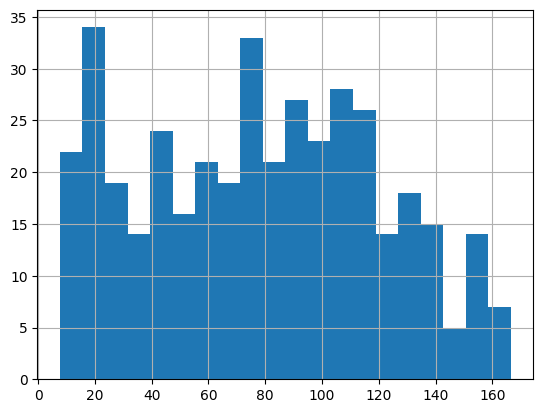

In [21]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [24]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [25]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [26]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [27]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [28]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [29]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n
existing_cards['age'] *= -1
existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 400


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
95,Azure Functions,Reasons to choose WebJobs over Azure Functions...,5dbe1e9c21756dabfafc61be2dab2409,-151.528118,79.850477,151.528118,1277.607631,0.010144,0,0
97,Azure Functions,Monitor: This pattern implements a recurring p...,356012bdd21c5dd8ed1e330d287cb0b4,-90.047595,79.850477,151.528118,1277.607631,0.010144,3,0
101,Azure Functions,Fan out/fan in: This pattern runs multiple fun...,27d702948647d6ee02788bbddca6e1e1,-76.911971,79.850477,151.528118,1277.607631,0.010144,6,0
104,Azure Functions,2. Suppose your Azure Function has a blob trig...,9d7bf60762cf8edfb888d6f7aaf00b31,-67.464044,79.850477,151.528118,1277.607631,0.010144,9,0
107,Azure Functions,"Function chaining: In this pattern, the workfl...",a58e28f259dc349e865828c55d75d5ac,-60.894918,79.850477,151.528118,1277.607631,0.010144,12,0
108,Azure Functions,You can use three durable function types: Clie...,042732a69490994c6100ea6a0d749d23,-53.583071,79.850477,151.528118,1277.607631,0.010144,15,0
37,Diffusers from Hugging Face,"Batch Size: In torch, batch size (len(prompt))...",027dbd3f7648b1365122572fb5805477,-158.480745,143.151224,158.480745,1431.512237,0.090048,0,0
40,Diffusers from Hugging Face,Scheduler (UniPCMultistepScheduler): A diffuse...,714e60b34b72275b331900cb0bb06083,-150.909710,143.151224,158.480745,1431.512237,0.090048,3,0
43,Diffusers from Hugging Face,Tokenizer (CLIPTokenizer): Provided by transfo...,bc4522b67d6baa044af56334d5e45d73,-136.836076,143.151224,158.480745,1431.512237,0.090048,6,0
46,Diffusers from Hugging Face,"UNet (UNet2DConditionModel): In diffusers, UNe...",38e465bebcf1d5c08cd97ba9729fd451,-126.451715,143.151224,158.480745,1431.512237,0.090048,9,0


## Age Sum

In [30]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [31]:
# n=6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [33]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
95,Azure Functions,Reasons to choose WebJobs over Azure Functions...,5dbe1e9c21756dabfafc61be2dab2409,-151.528118,79.850477,151.528118,1277.607631,0.010144,0,0
97,Azure Functions,Monitor: This pattern implements a recurring p...,356012bdd21c5dd8ed1e330d287cb0b4,-90.047595,79.850477,151.528118,1277.607631,0.010144,3,0
101,Azure Functions,Fan out/fan in: This pattern runs multiple fun...,27d702948647d6ee02788bbddca6e1e1,-76.911971,79.850477,151.528118,1277.607631,0.010144,6,0
104,Azure Functions,2. Suppose your Azure Function has a blob trig...,9d7bf60762cf8edfb888d6f7aaf00b31,-67.464044,79.850477,151.528118,1277.607631,0.010144,9,0
107,Azure Functions,"Function chaining: In this pattern, the workfl...",a58e28f259dc349e865828c55d75d5ac,-60.894918,79.850477,151.528118,1277.607631,0.010144,12,0
108,Azure Functions,You can use three durable function types: Clie...,042732a69490994c6100ea6a0d749d23,-53.583071,79.850477,151.528118,1277.607631,0.010144,15,0
37,Diffusers from Hugging Face,"Batch Size: In torch, batch size (len(prompt))...",027dbd3f7648b1365122572fb5805477,-158.480745,143.151224,158.480745,1431.512237,0.090048,0,0
40,Diffusers from Hugging Face,Scheduler (UniPCMultistepScheduler): A diffuse...,714e60b34b72275b331900cb0bb06083,-150.909710,143.151224,158.480745,1431.512237,0.090048,3,0
43,Diffusers from Hugging Face,Tokenizer (CLIPTokenizer): Provided by transfo...,bc4522b67d6baa044af56334d5e45d73,-136.836076,143.151224,158.480745,1431.512237,0.090048,6,0
46,Diffusers from Hugging Face,"UNet (UNet2DConditionModel): In diffusers, UNe...",38e465bebcf1d5c08cd97ba9729fd451,-126.451715,143.151224,158.480745,1431.512237,0.090048,9,0


In [34]:
existing_cards.head(10)['age'].sum()

np.float64(-1073.1079626394842)